### Date Preprocessing

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
import random as python_random

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

# set seed
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# data preprocessing to float32
def get_preprocessed_data(images, labels):
    
    images = np.array(images/255.0, dtype=np.float32)

    
    return images, labels

# data preprocessing to one hot encoding
def get_preprocessed_ohe(images, labels):
    
    images, labels = get_preprocessed_data(images, labels)
    oh_labels = to_categorical(labels)
    
    return images, oh_labels

# train/validation/test split
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels)



In [3]:
# set random seed
set_random_seed(2021)

In [4]:
# CIFAR10 dataset load
(train_images, train_labels), (test_images, test_labels) = \
    cifar10.load_data()

print('train dataset shape: ', train_images.shape, train_labels.shape)
print('test dataset shape: ', test_images.shape, test_labels.shape)

train dataset shape:  (50000, 32, 32, 3) (50000, 1)
test dataset shape:  (10000, 32, 32, 3) (10000, 1)


In [5]:
# CIFAR10 dataset preprocessing & split
(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)

print('train dataset shape: ', tr_images.shape, tr_oh_labels.shape)
print('validation dataset shape: ', val_images.shape, val_oh_labels.shape)
print('test dataset shape: ', test_images.shape, test_oh_labels.shape)

train dataset shape:  (42500, 32, 32, 3) (42500, 10)
validation dataset shape:  (7500, 32, 32, 3) (7500, 10)
test dataset shape:  (10000, 32, 32, 3) (10000, 10)


In [6]:
IMAGE_SIZE = 32

### Model Create Function

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

def create_model(verbose=False):
    
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    
    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    
    x = Flatten(name='flatten')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(300, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.3)(x)
    
    output = Dense(10, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)

    if verbose:
        model.summary()
    
    return model
    

In [8]:
!rm *.hdf5

zsh:1: no matches found: *.hdf5


In [9]:
import os

current_path = os.getcwd()
print('current path: ', current_path)

current path:  /Users/jamm/Documents/Github/AI/DeepLearning_CNN/CIFAR10_CNN


### Callbacks

In [10]:
mcp_cb = ModelCheckpoint(
    filepath=current_path + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    model='min',
    period=1,
    verbose=0
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    mode='min',
    verbose=1
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=1
)

### Compile & Fit

In [11]:
model = create_model()

model.compile(
    optimizer=Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x=tr_images,
    y=tr_oh_labels,
    batch_size=32,
    epochs=30,
    shuffle=True,
    validation_data=(val_images, val_oh_labels),
    callbacks=[mcp_cb, rlr_cb, ely_cb]
)

Metal device set to: Apple M1


2021-08-20 13:14:44.996645: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-20 13:14:44.996741: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/jamm/miniforge3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-08-20 13:14:45.275207: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-20 13:14:45.275398: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30
   1/1329 [..............................] - ETA: 8:52 - loss: 3.3774 - accuracy: 0.1250

2021-08-20 13:14:45.494240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: 1.5534 - accuracy: 0.4349

2021-08-20 13:15:12.221482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 29s 21ms/step - loss: 1.5534 - accuracy: 0.4349 - val_loss: 2.1748 - val_accuracy: 0.3211
Epoch 2/30
1329/1329 [==============================] - 28s 21ms/step - loss: 1.1183 - accuracy: 0.6011 - val_loss: 1.2018 - val_accuracy: 0.5916
Epoch 3/30
1329/1329 [==============================] - 28s 21ms/step - loss: 0.9228 - accuracy: 0.6752 - val_loss: 0.8760 - val_accuracy: 0.6949
Epoch 4/30
1329/1329 [==============================] - 28s 21ms/step - loss: 0.8246 - accuracy: 0.7134 - val_loss: 0.8571 - val_accuracy: 0.6980
Epoch 5/30
1329/1329 [==============================] - 28s 21ms/step - loss: 0.7345 - accuracy: 0.7482 - val_loss: 0.7112 - val_accuracy: 0.7583
Epoch 6/30
1329/1329 [==============================] - 28s 21ms/step - loss: 0.6537 - accuracy: 0.7765 - val_loss: 0.8249 - val_accuracy: 0.7200
Epoch 7/30
1329/1329 [==============================] - 28s 21ms/step - loss: 0.5961 - accuracy: 0.7974 - val_loss: 0.6224 - val_accura

### Evaluate

In [12]:
model.evaluate(test_images, test_oh_labels)

313/313 [==============================] - 3s 10ms/step - loss: 0.7051 - accuracy: 0.8201


[0.7050707936286926, 0.8201000094413757]

In [13]:
!ls -lia

total 67456
5892047 drwxr-xr-x  17 jamm  staff      544  8 20 13:27 .
5109589 drwxr-xr-x  11 jamm  staff      352  8 20 13:12 ..
5892142 drwxr-xr-x   7 jamm  staff      224  8 20 12:14 .ipynb_checkpoints
5945315 -rw-r--r--   1 jamm  staff    31256  8 16 20:54 CIFAR10_CNN_Batch_Normalization_Practice.ipynb
6133863 -rw-r--r--   1 jamm  staff    18498  8 20 13:27 CIFAR10_CNN_Callback_Filters_Practice.ipynb
5926369 -rw-r--r--   1 jamm  staff    44970  8 16 20:54 CIFAR10_CNN_Kernel(Weights)_Initializer_Practice.ipynb
5892184 -rw-r--r--   1 jamm  staff   996341  8 16 18:31 CIFAR10_CNN_Practice.ipynb
6091419 -rw-r--r--   1 jamm  staff   222519  8 19 22:11 CIFAR10_CNN_Shuffle_Practice.ipynb
6137864 -rw-r--r--   1 jamm  staff  3689408  8 20 13:15 weights.01-2.17.hdf5
6137876 -rw-r--r--   1 jamm  staff  3689408  8 20 13:15 weights.02-1.20.hdf5
6137887 -rw-r--r--   1 jamm  staff  3689408  8 20 13:16 weights.03-0.88.hdf5
6137902 -rw-r--r--   1 jamm  staff  3689408  8 20 13:16 weights.04-0.86.hdf5


### 최적 weight를 모델로 재로딩한 다음 테스트 데이터로 다시 평가

In [14]:
model = create_model()
model.compile(
    optimizer=Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.load_weights(current_path + '/weights.16-0.51.hdf5')

In [15]:
model.evaluate(test_images, test_oh_labels)

 13/313 [>.............................] - ETA: 2s - loss: 0.4846 - accuracy: 0.8486

2021-08-20 13:31:44.399512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 10ms/step - loss: 0.5388 - accuracy: 0.8297


[0.5388439297676086, 0.8297000527381897]

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    

### Filters x 2 

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

def create_model(verbose=False):
    
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    
    x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=512, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    
    x = Flatten(name='flatten')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(300, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.3)(x)
    
    output = Dense(10, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)

    if verbose:
        model.summary()
    
    return model

In [8]:
model = create_model()

Metal device set to: Apple M1


2021-08-22 18:48:55.349844: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-22 18:48:55.350300: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0     

### Callbacks

In [10]:
rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    mode='min',
    verbose=1
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=1
)

In [11]:
model.compile(
    optimizer=Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x=tr_images,
    y=tr_oh_labels,
    batch_size=32,
    epochs=32,
    shuffle=True,
    validation_data=(val_images, val_oh_labels),
    callbacks=[rlr_cb, ely_cb]
)

/Users/jamm/miniforge3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-08-22 18:49:03.757949: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-22 18:49:03.760727: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/32


2021-08-22 18:49:04.020931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: 1.8591 - accuracy: 0.3072

2021-08-22 18:50:22.753457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 83s 62ms/step - loss: 1.8591 - accuracy: 0.3072 - val_loss: 1.6300 - val_accuracy: 0.4319
Epoch 2/32
1329/1329 [==============================] - 82s 62ms/step - loss: 1.4375 - accuracy: 0.4539 - val_loss: 1.3616 - val_accuracy: 0.5084
Epoch 3/32
1329/1329 [==============================] - 82s 62ms/step - loss: 1.2257 - accuracy: 0.5529 - val_loss: 1.0155 - val_accuracy: 0.6529
Epoch 4/32
1329/1329 [==============================] - 83s 62ms/step - loss: 1.0841 - accuracy: 0.6119 - val_loss: 0.9830 - val_accuracy: 0.6600
Epoch 5/32
1329/1329 [==============================] - 83s 62ms/step - loss: 0.9764 - accuracy: 0.6552 - val_loss: 0.8433 - val_accuracy: 0.7188
Epoch 6/32
1329/1329 [==============================] - 82s 62ms/step - loss: 0.8628 - accuracy: 0.7020 - val_loss: 0.9044 - val_accuracy: 0.7223
Epoch 7/32
1329/1329 [==============================] - 83s 62ms/step - loss: 0.7724 - accuracy: 0.7320 - val_loss: 0.7017 - val_accura

313/313 [==============================] - 6s 18ms/step - loss: 0.7890 - accuracy: 0.8740


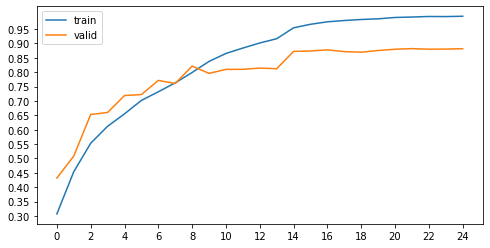

In [14]:
model.evaluate(test_images, test_oh_labels)
show_history(history)